In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from JuliaODE import*
from JuliaGyroSolver import*
from JuliaPhysicalQTE import*

import diffeqpy
from diffeqpy import de, ode

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


  Activating project at `~/.julia/environments/diffeqpy`
  Activating project at `~/.julia/environments/diffeqpy`


In [2]:
g = 9.81           # m/s^2
m = 0.375          # kg
J3 = 0.000055      # kg.m^2
J1 = 0.000055      # kg.m^2
h = 31.25 * 1e-3   # m
x0 =  0.1
f_exc = 0.265
Phi = np.pi

params = [g, m, h, J1, J3 , x0, Phi, f_exc]
CI = [np.pi / 6, 0, 0, 0, 0, 2 * np.pi * 200]

p_psi0 = J3 * CI[-1]

print('f_R =', m*h*x0 *  (2 * np.pi * (f_exc)**2 / p_psi0   ))

f_R = 0.007481356534090911


In [3]:
plt.rcParams.update({"text.usetex": True, "font.family": "serif"})

In [4]:
f_L_0 = 0.265 


f_R_0 = m*h*x0 *  (2 * np.pi * (f_exc)**2 / p_psi0   ) / 2
#f_R_0 = f_L_0 / 70.770

tab_t_burst = np.linspace(0, 1000, 101, endpoint=True)
tab_exc_freq = np.linspace(0.92 * f_L_0, 1.08 * f_L_0, 101, endpoint=True)

delta = tab_exc_freq - f_L_0

In [5]:
RabiXY_num = (1 - np.cos(np.loadtxt("RabiXY_200.txt")) ) / 2

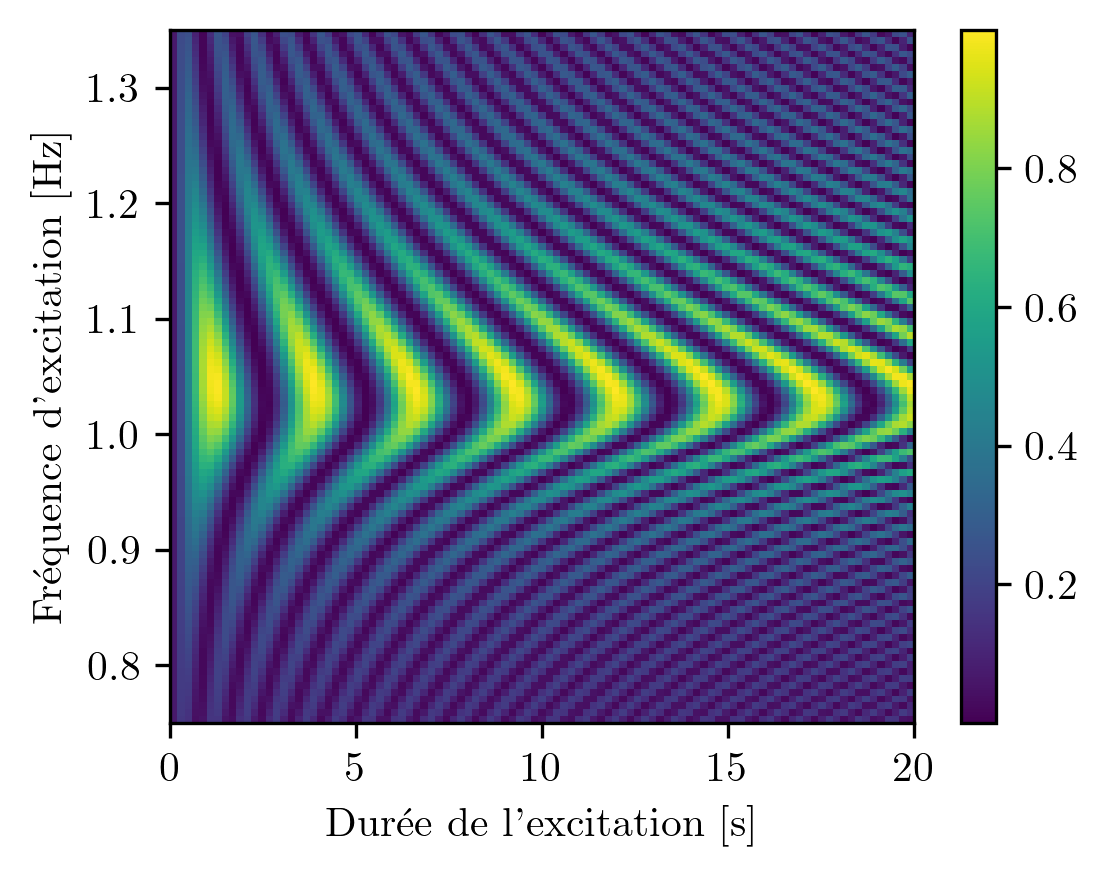

In [6]:
plt.figure(figsize=(4, 3), dpi = 300)
plt.imshow(RabiXY_num, origin = "lower", extent=[0, 20, 0.75, 1.35], aspect="auto")
plt.xlabel("Durée de l'excitation [s]")
plt.ylabel("Fréquence d'excitation [Hz]")
plt.colorbar()
plt.show()

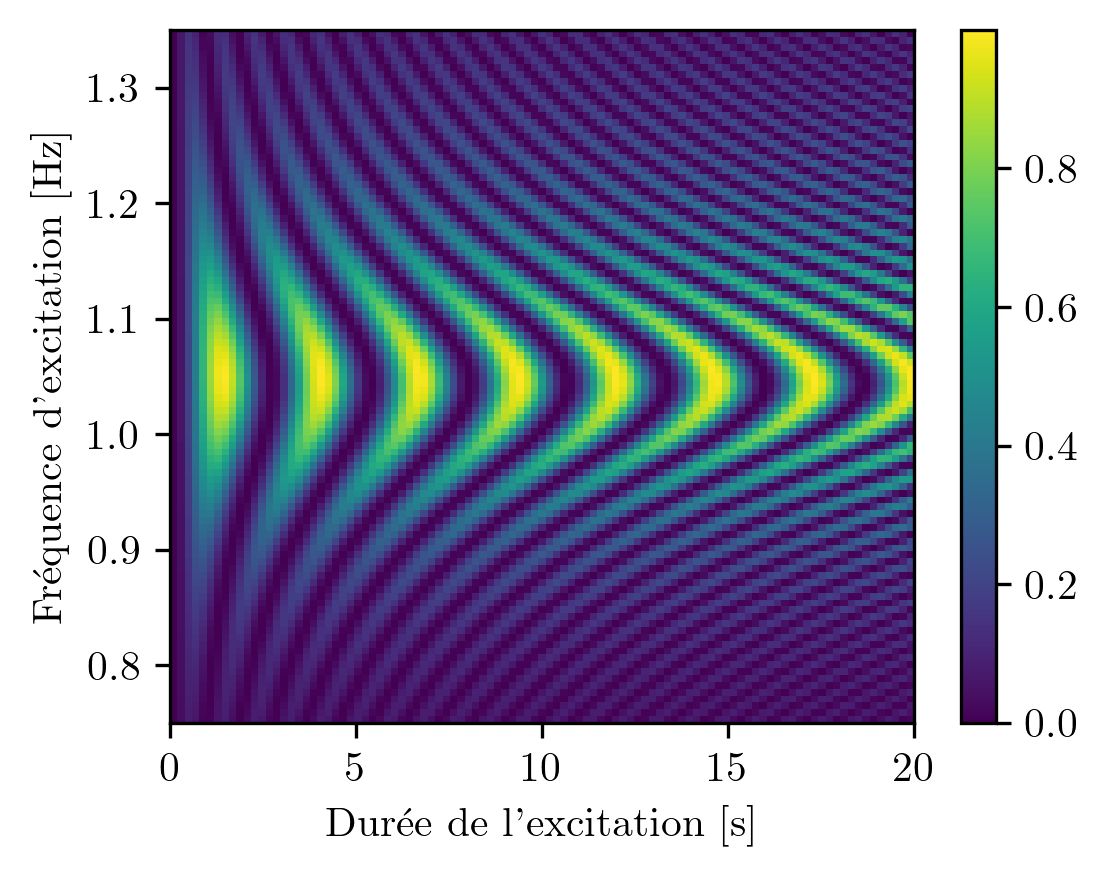

In [7]:
def Rabi_Freq_Modified(delta, f_R, f_L):
    return 2 * f_R * (1 + delta / f_L)**2


def Rabi_Assym(t_burst, delta, f_R, f_L):
    tab_Rabi_th = np.zeros((len(delta), len(t_burst)))
    for i in range(len(delta)):
        for j in range(len(t_burst)):
            f_R_mod = Rabi_Freq_Modified(delta[i], f_R, f_L)
            pulsation = 2 * np.pi * np.sqrt(delta[i]**2 + (f_R_mod)**2) / 2
            num = (f_R_mod**2) * np.sin( pulsation * t_burst[j] )**2
            den = f_R_mod**2 + delta[i]**2
            tab_Rabi_th[i, j] = num / den
    return tab_Rabi_th



RabiXY_th = Rabi_Assym(tab_t_burst, delta, f_R_0, f_L_0)


plt.figure(figsize=(4, 3), dpi = 300)
plt.imshow(RabiXY_th, origin = "lower", extent=[0, 20, 0.75, 1.35], aspect="auto")
plt.xlabel("Durée de l'excitation [s]")
plt.ylabel("Fréquence d'excitation [Hz]")
plt.colorbar()
plt.show()

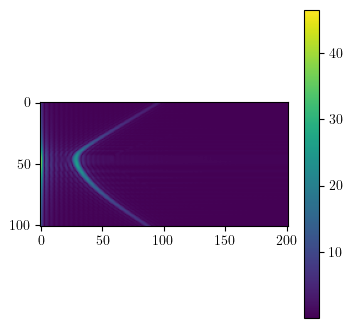

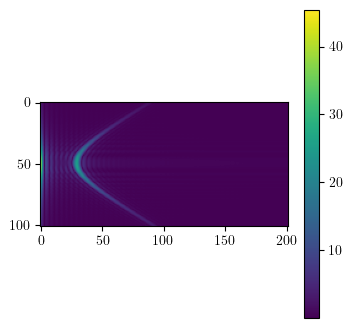

In [8]:
signal = RabiXY_num


n = int(len(signal) * 4)


fourier_num = np.fft.rfft(signal, n)

sample_rate = 10
freq_Benji = np.fft.rfftfreq(n, d=1/sample_rate)

fourier_num = np.delete(fourier_num, [0], axis=1)

plt.figure(figsize=[4 ,4])
plt.imshow(np.abs(fourier_num))
plt.colorbar()
plt.show()

A_num = np.abs(fourier_num)

signal = RabiXY_th



fourier_th = np.fft.rfft(signal, n)

sample_rate = 10
freq_Benji = np.fft.rfftfreq(n, d=1/sample_rate)

fourier_th = np.delete(fourier_th, [0], axis=1)

plt.figure(figsize=[4 ,4])
plt.imshow(np.abs(fourier_th))
plt.colorbar()
plt.show()

A_th = np.abs(fourier_th)


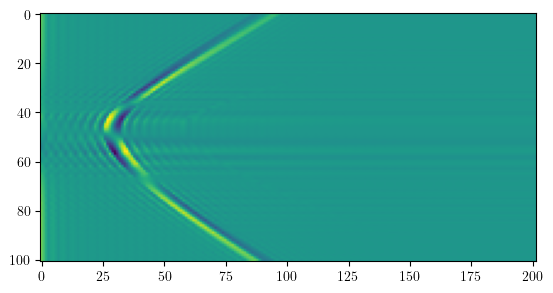

In [9]:
plt.imshow(A_num - A_th)

In [10]:
list_max = []

for l in A_num:
    #list_max.append(np.argmax(l[1:]))
    list_max.append( freq_Benji[np.argmax(l[2:]) + 2] )

list_max = np.array(list_max)

np.min(list_max)

0.7178217821782178

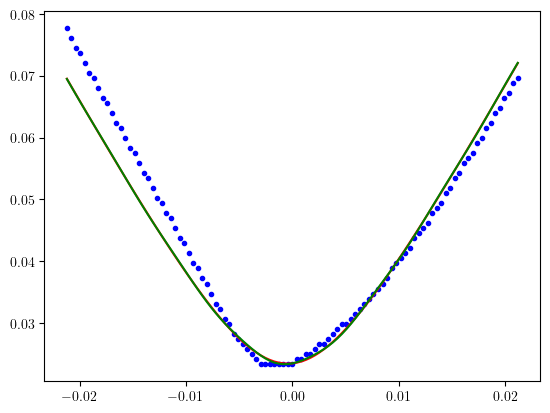

In [19]:
from scipy.optimize import curve_fit


def Rabi_Freq_Modified(delta, f_R, f_L):
    return 2 * f_R * (1 + delta / f_L)**2


def New_Rabi(delta, f_R, f_L):
    return 2 * f_R * (1 + delta * ( 1 + np.sinc( delta * tab_t_burst[-1] / np.pi ) ) / f_L)**2


def Pulsate(delta, f_R_0, f_L_0):
    return 2 * np.pi * np.sqrt( delta**2 + Rabi_Freq_Modified(delta, f_R_0, f_L_0)**2 ) / 2


def New_Pulsate(delta, f_R_0, f_L_0):
    return 2 * np.pi * np.sqrt( delta**2 + New_Rabi(delta, f_R_0, f_L_0)**2 ) / 2

Y_th = Pulsate(delta, f_R_0, f_L_0)

coeff = np.min(Y_th) / np.min(list_max)

Y_num = coeff * list_max


#plt.plot(delta, coeff * list_max, 'b')
#plt.plot(delta, Pulsate(delta, f_R_0, f_L_0), 'r')

#F = np.polyfit(delta, Y_num, deg=3)
#print(F)

def Fit_Model(delta, a, b, c, d):
    return a +  delta * b + (delta**2) * c + (delta**3) * d

tab, pcov = curve_fit(Fit_Model, delta, Y_num, p0=[0,0,0,0])

plt.scatter(delta, coeff * list_max, color='b', marker='.')
plt.plot(delta, Pulsate(delta, f_R_0, f_L_0), 'r')
plt.plot(delta, New_Pulsate(delta, f_R_0, f_L_0), 'g')

#plt.plot(delta, Fit_Model(delta, *tab), 'k--')